<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/wound_care_emergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Unsupervised, Generative Knowledge Graphs
  Produce enormous graph networks, based on time-series correlation between topics
  1.  Get an OpenAi token, save to a file and import, ex. 'openai_key'
  2.  Input list of seed topics that you want expanded upon
  3.  Experiment with new variations in OpenAi questioning format

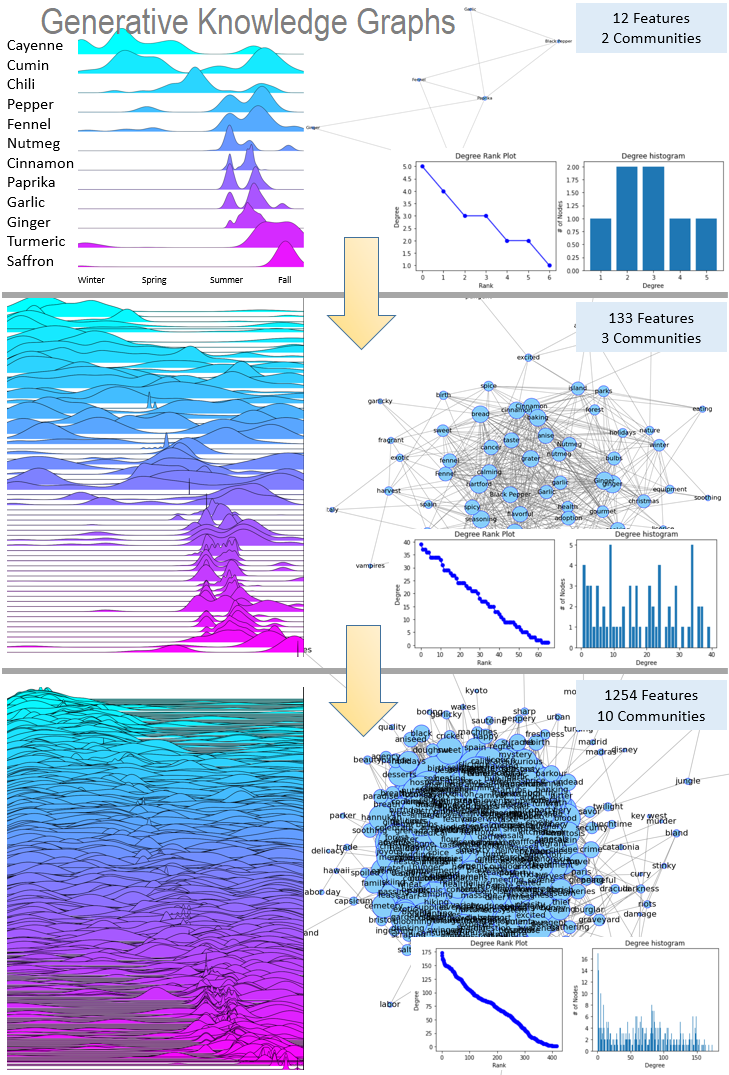

## installs

In [1]:
!pip install pytrends
!pip install joypy

# install openai
!pip install openai

# install dgl
!pip install dgl

# jupyter viz
!pip install visJS2jupyter

# install transformers
!pip install transformers -q

# install neo4j gds
!pip install graphdatascience

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16126 sha256=2484f9b10116cc672fcc3fad41df580efaefb069483dd8ed171b5f5d265419d8
  Stored in directory: /root/.cache/pip/wheels/07/6f/5c/8174f98dec1bfbc7d5da4092854afcbcff4b26c3d9b66b5183
Successfully built pytrends
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 8.9 MB/s 
  Created wheel for openai: filename=openai-0.23.0-py3-none-any.whl size=54478 sha256=7eea6a7fc74d244b2b48f6e9c752613815340c5b16c3cd54cda9aa88518de301
  Stored in directory: /

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for visJS2jupyter: filename=visJS2jupyter-0.1.16-py3-none-any.whl size=22473 sha256=bcd5c67d7ff59798be5235e2bfdf4babb0c7f5fb301851fba7fcd48440b341f7
  Stored in directory: /root/.cache/pip/wheels/72/c8/3a/7de50e62a8924510c97dc8536b7620b4fdbe03ee1ff5ce2c1a
Successfully built visJS2jupyter
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 43.1 MB/s 
     |████████████████████████████████| 120 kB 56.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 503 kB/s 
     |████████████████████████████████| 95 kB 155 kB/s 
  Created wheel for neo4j: filename=neo4j-4.4.5-py3-none-any.whl size=123291 sha256=49e68277757694784aa3936d7920f343559739537f2cd2224769066d57657a62
  Stored in directory: /root/.cache/pip/wheels/73/62/2d/6532ffe

## imports

In [2]:
import numpy
import pandas 
import re
import string
import os

import time 
from difflib import SequenceMatcher

from pytrends.request import TrendReq
from pytrends         import dailydata
import pytrends
from operator         import index

import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import openai

import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import visJS2jupyter.visualizations as visualizations

# supply openai api key via file 
openai.api_key = open('openai_key').read()
#openai.api_key = 'rrtt'

# LM transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed

# pytorch
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import gc
gc.collect

# graph data science - neo4j
from graphdatascience import GraphDataScience 
from neo4j import GraphDatabase

# import BLOOM models
# model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-1b3", use_cache=True)
# tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-1b3")

# model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-350m", use_cache=True)
# tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-350m")


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:
# neo4j aurads connection
AURA_CONNECTION_URI = "neo4j+s://6e96e772.databases.neo4j.io"
AURA_USERNAME = "neo4j"
AURA_PASSWORD = open('neo4j_key.txt').read()

# Client instantiation
gds = GraphDataScience(
    AURA_CONNECTION_URI,
    auth=(AURA_USERNAME, AURA_PASSWORD),
    aura_ds=True
)

# confirm connection
print(gds.version())

2.1.9


## seed config

In [56]:
### Generative Seeds, topics and question formatting to feed to OpenAi

# dispaly neo4j cypher commands for learning and debug
cypher_echo = True

# seed topics
# topics = ['Type 1 diabetes', 'Type 2 diabetes', 'Cardiovascular disease', 'Rheumatoid arthritis'
#         ,'Coronary artery disease', 'Multiple sclerosis', 'Stroke', 'Clots', 'Hemorrhage', 'Epilepsy '
#         ,'Arthritis', 'Cancer', 'High blood pressure', 'Obesity', 'Alzheimer', 'Hospice', 'Tooth decay']

# decapitalized
topics = ['diabetes', 'cardiovascular disease', 'rheumatoid arthritis', 'pressure ulcers', 'venousstasious ulcers'
         ,'coronary artery disease', 'multiple sclerosis', 'stroke', 'clots', 'hemorrhage', 'epilepsy '
         ,'arthritis', 'cancer', 'high blood pressure', 'obesity', 'alzheimer', 'tooth decay','arterial', 'trauma wound', 'soft tissue necrousis']

context = ['elderly', 'diabetic', 'pregant', 'man', 'women']

perspective = ['texas', 'california', 'new york', 'mid west', 'south', 'florida']

# topics = ['diabetic ulcers', 'pressure ulcers', 'venousstasious ulcers'
#         , 'arterial', 'trauma wound', 'soft tissue necrousis', 'heart condition','healing']

relatives = [ 'diet', 'activities', 'regional'
          , 'holidays', 'seasonal'] 

# relatives = ['life style choices', 'diet', 'behavior', 'activities'
#          , 'holidays', 'yearly events', 'monthly', 'seasonal'] 


# request object



#req_obj = ['concepts', 'styles', 'cities', 'emotions','concerns', 'attitudes', 'alternatives', 'regions'
#         , 'life events', 'yearly events', 'life style', 'behaviors', 'memories', 'mistakes', 'goals'
#         , 'holidays']


regex = re.compile('[^a-zA-Z ]')

### Generative Bounds, prescribe factors needed to control generative iterations

# connection strenth minimum boost, base on standard deviation
std_factor = .2
std_factor = 0
pop_threshold = 0

# batch size
batch_size = 30

# max fetch
max_fetch = 50

# max relationship strength
max_similarity = 0.95

## helper functions
  1. get_trend_frame(topics, years): 
          returns a dataframe of topic trends
  2. stack_nodes_vertically(df_features): 
          form graph source/target relationships
  3. build_node_labels(df_flat): 
          generate labels based on time interval
  4. get_ridgeplot(df_flat):
          visualize temporal attributes
  5. get_openai_response(question):
          using standard format, prompt openai for new top lists
  6. get_pairwise_similarity(df_features, topics, std_factor): 
          for combinations of topics, get temporal correlation
  7. swap_tokens(chk_topics, new_topics):
          replace any duplicates between existing and new features
  8. build_graph_network(df_slice):
          buiod graph
  9. get_openai_generated_topics(topic, obj):
          form openAi question given generative seeds
  10. get_related_topics(df):
          mechanism for enhancing graph based on generative seeds
  11. get_graph_degree(G):
          get graph statisitcs for feeding into downstream predictive models

In [5]:
### 1. for a given list of topics, return dataframe of interests from pytrend
def get_trend_frame(topics, years, state_code):

  # batch management
  batch_counter = 0
  batch_idx = 0
  fetch_idx = 0

  # initialize return frame
  df_total = pandas.DataFrame()

  # for each provided TOPIC
  for topic in topics:

    if fetch_idx > max_fetch:
      print('hit local max of %d' % (fetch_idx))
      break

    # prevent saturation of api endpoint
    if batch_counter > batch_size:
      print('')
      batch_idx+=1
      print('completed retrieval of batch %d - %d rows of %d' % (batch_idx, round(batch_idx * batch_size), len(topics) ))
      batch_counter=0
      time.sleep(30)


    # pytrend request
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[topic]
                         ,geo=( "US-%s" % (state_code) )
                         ,timeframe=( 'today %s-y' % (years)))
    
    # load trend request
    df = pytrend.interest_over_time()

    # counters
    batch_counter+=1
    fetch_idx+=1

    try:

      # add column for new topic
      df_total[topic] = df[topic]


    except:
      print('failed to add topic - %s ' % (topic))


  # drop nans
  df_total = df_total.dropna()

  # return standard frame
  return df_total

In [6]:
### 2. for each topic and interval of time, stack a vertical dataframe of value counts
def stack_nodes_vertically(df_features):

  # initialize buffers resources
  df_stk=pandas.DataFrame()
  globalst=[]

  # for each feature
  for col in df_features:                      # topic

      # for each time interval
      for val in df_features.index.weekofyear: # weeknum

          try:

            # time sensitive
            fs_val = df_features[col][val]       # full spectrum
                
            if fs_val > pop_threshold:

              # iterate through each instance of max bin occurence, determining number of weeks written
              for x in range(0,int(abs(fs_val) * 100)):
                
                  # build buffer list
                  lst = [val, val, col]
                  globalst.append(lst)

            else:
                  # build buffer list
                  lst = [val, None, None]
                  globalst.append(lst)

          except Exception as e: # work on python 3.x
              print(col)              
              print(val)
              print(fs_val)
              print('Failed to upload to ftp: '+ str(e))

  # materialize vertically flattened
  df_flat = pandas.DataFrame(globalst
                            ,columns=['WeekNum'
                            ,'WeekNum_Rct'
                            ,'Flower_Tot'])
  
  return df_flat

In [7]:
### 3. prefix ridgemap/joyplot labels with weeknum average
def build_node_labels(df_flat):
  
  # get all distinct nodes
  df_stats = df_flat.groupby('Flower_Tot').agg(['mean', 'count']).reset_index()

  # rename columns to node labels
  df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]

  # sort by average time interval
  df_stats = df_stats.sort_values(by='WeekNum mean',ascending=True)

  # include average into node label
  df_stats['Name'] = ( ( df_stats['WeekNum mean'] * 100) + 1000).astype('int').astype('str') + ' '+ df_stats['Flower_Tot']

  # update flattened node space with averaged names
  for index, row in df_stats.iterrows():
      df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])

  return df_flat

In [8]:
### 4. display ridgeplot of time frame, for 
def get_ridgeplot(df_flat):


  # colors = ["lightgray", "lightgreen", "yellowgreen", "lightgreen", "lightgray"]
  # colors = ["white", "lightgray", "lightgreen", "lightgray", "white"]
  colors = ["white", "#6DC14C", "white"]  
  cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

  # configure and build ridgeplot
  fig, axes = joypy.joyplot(df_flat
                            , column=['WeekNum', 'WeekNum_Rct']
                            , by='Flower_Tot'
                            , overlap=1.2
                            , fill=True
                            , figsize=(22,22)
                            , x_range = [0,52]
                            , colormap=cmap1
                            # , colormap=cm.YlGn                         
                            , ylim='own'
                          )


  # write ridgeplot
  # plt.savefig(('/content/drive/MyDrive/frank_jj_%s.png' % (len(df_flat))) )
  # plt.savefig(my_path + '/Sub Directory/graph.png')


  # plot
  plt.show()

In [9]:
### 5. send openai question, receive response
def get_openai_response(question):

    # format open au request
    response = openai.Completion.create(
                      engine="text-davinci-001",
                      prompt=question,
                      temperature=.5,
                      max_tokens=250,
                      top_p=1,
                      frequency_penalty=50,
                      presence_penalty=0 )

    # parse and process open ai response
    response_choices = response["choices"]

    # replace blanks
    response = response_choices[0]["text"].strip('\n')

    return response

In [10]:
def swap_tokens(chk_topics, new_topics):

  buffer_lst = []

# for each graphed topics
  for chk_topic in chk_topics:

    buffer_lst.append(chk_topic)


  for new_topic in new_topics:

    # token validation checks

      new_topic_split = new_topic.split()
    
    # 1. check that not preceeded by short word
      if len(new_topic_split[0]) < 3:

        try:
          new_topic = new_topic_split[1]
        except:
          pass
        

      buffer_lst.append(new_topic)


  return buffer_lst


In [11]:
def get_pairwise_similarity(df_features, topics, std_factor):

  # pair wise correlation / similarity
  c = df_features.corr().abs()

  # flatten and sort
  so = c.unstack().sort_values(kind="quicksort")

  # remove low connections
  min_connection_strength = so.mean() + ( std_factor * so.std() )
  min_connection_cutoff = len(so) - len(so[so > min_connection_strength])

  # turn to frame
  df_slice = so[min_connection_cutoff:-len(topics)].to_frame()

  df_slice.reset_index(inplace=True)

  df_slice.columns = ['source','target','weight']

  return df_slice

In [12]:
def build_graph_network(df_slice):

  # build graph 
  G = nx.from_pandas_edgelist(df_slice
                            ,'source'          # parent
                            ,'target'          # child
                            , ['weight'])      # relationship


  # define plot area
  plt.figure(3,figsize=(22,22)) 

  # calc degrees per node
  d = dict(G.degree)

  # visualize graph 
  nx.draw(G         
      ,nx.kamada_kawai_layout(G)               
      ,with_labels=True
      ,edge_color='gray'
      ,node_color='#6DC14C'
      ,node_size=[v * 700 for v in d.values()]
      ,font_size=22)
  
  ax = plt.gca() # to get the current axis
  ax.collections[0].set_edgecolor("blue")

  return G

In [13]:
def get_related_topics(df, context, perspective):

  lst_buffer = []
  graph_topics = list(df['source'].unique())

  # batch management
  batch_counter = 0
  batch_idx = 0
  fetch_idx = 0

  # TOPICS
  for graph_topic in graph_topics:

    # if match is hit
    if fetch_idx > max_fetch:
      print('hit local max of %d' % (fetch_idx))
      break

    # RELATIVE ITERATOR 
    for obj in relatives:

      # prevent saturation of api endpoint
      if batch_counter > batch_size:
        print('')
        batch_idx+=1
        print('completed openai retrieval of batch %d - %d rows of %d' % 
              (batch_idx, round(batch_idx * batch_size)
              , len(graph_topics) * len(relatives) ))
        batch_counter=0
        time.sleep(30)

      topic_list = get_openai_generated_topics(graph_topic, obj, perspective)

      print(topic_list)

      for topic in topic_list:

        topic = topic.translate(string.punctuation)
        topic = re.sub(r'[^\w\s]','',topic)

        if len(topic) < 10 and len(topic) > 4:

          lst_buffer.append(topic)
        fetch_idx+=1
      
      # counters
      batch_counter+=1
      
      print(lst_buffer)
    
  return lst_buffer

In [14]:
def get_graph_degree(G):
  degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
  dmax = max(degree_sequence)

  fig = plt.figure("Degree of a random graph", figsize=(8, 8))
  # Create a gridspec for adding subplots of different sizes
  axgrid = fig.add_gridspec(5, 4)

  ax0 = fig.add_subplot(axgrid[0:3, :])
  Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
  pos = nx.spring_layout(Gcc, seed=10396953)
  nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
  nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
  ax0.set_title("Connected components of G")
  ax0.set_axis_off()

  ax1 = fig.add_subplot(axgrid[3:, :2])
  ax1.plot(degree_sequence, "b-", marker="o")
  ax1.set_title("Degree Rank Plot")
  ax1.set_ylabel("Degree")
  ax1.set_xlabel("Rank")

  ax2 = fig.add_subplot(axgrid[3:, 2:])
  ax2.bar(*numpy.unique(degree_sequence, return_counts=True))
  ax2.set_title("Degree histogram")
  ax2.set_xlabel("Degree")
  ax2.set_ylabel("# of Nodes")

  fig.tight_layout()
  plt.show()

In [15]:
### BLOOM - Generate Bloom response model
def get_bloom_response(question):

  # response = model.generate(**question
  #                         , num_beams = 2
  #                         , num_beam_groups = 2
  #                         , top_k=1
  #                         , temperature=0.9
  #                         , repetition_penalty = 2.0
  #                         , diversity_penalty=2.0
  #                         , max_new_tokens = 20)
  
  response = model.generate(**question
                          , max_length = 100
                          , repetition_penalty = 2.0
                          , top_k = 0
                          , temperature=0.9)  
  
  print(response)
  
  return response



In [16]:
### BLOOM - Form request
def prompt_bloom(question):

  # initiate tokenizer
  input_tokens = tokenizer(question, return_tensors="pt").to(0)

  # build sentence and retrieve 
  retrieval = get_bloom_response(input_tokens)

  # decode retrieval
  retrieval = tokenizer.decode(retrieval[0], truncate_before_pattern=[r"\n\n^#", "^'''","\n\n\n"])

  print(retrieval)

  # remove prompt from response
  retrieval = retrieval.replace(question, '')

  # replace blanks
  retrieval = retrieval.strip()
  
  # replace non-alphabet chars
  retrieval = regex.sub('', retrieval)

  return retrieval

In [17]:
### 
# topic = 
# obj = relative
# state = perspective
def get_openai_generated_topics(topic, obj, state):
  
  new_tokens_list = []

  responses = []

  # question = 'from the perspetive of a %s resident, list several %s topics linked to %s' % ( state , obj , topic )
  question = 'from the perspetive of %s resident, list single words %s topics linked to %s' % ( state , obj , topic )

  # retrieve 
  # retrieval = get_openai_response('from the perspetive of a %s resident, list several single word %s related to %s' % ( state , obj , topic ))
  # retrieval = get_bloom_response('from the perspetive of a %s resident, list several single word %s related to %s' % ( state , obj , topic ))
  # retrieval = prompt_bloom('from the perspetive of a %s resident, list several single word %s related to %s' % ( state , obj , topic ))
  # retrieval = prompt_bloom('list topics related to %s' % ( topic ))
  # retrieval = prompt_bloom('from the perspetive of a %s resident, list several %s topics linked to %s' % ( state , obj , topic ))
  retrieval = get_openai_response('from the perspetive of %s resident, list single words %s topics linked to %s' % ( state , obj , topic ))
  # retrieval = prompt_bloom(question)

  print(question)

  # retrieval = get_openai_response('list one word %s related to %s' % (obj , topic))
  responses.append(retrieval)

  print(responses)

  new_tokens = re.split("; |, |\*|\n",responses[0].lower())

  return new_tokens

In [18]:
# neo4j connection class
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response


conn = Neo4jConnection(uri=AURA_CONNECTION_URI, 
                       user=AURA_USERNAME,              
                       pwd=AURA_PASSWORD)

In [19]:
def insert_data(query, rows, batch_size = 10000):

    # Function to handle the updating the Neo4j database in batch mode.
    total = 0
    batch = 0
    start = time.time()
    result = None
    
    # return cypher query for learning opportunity
    if cypher_echo:
      print(query)
    
    # batch processing
    while batch * batch_size < len(rows):

        res = conn.query(query, 
                         parameters = {'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        
        total += res[0]['total']
        batch += 1
        result = {"total":total, 
                  "batches":batch, 
                  "time":time.time()-start}
        
    return result

In [20]:
def add_nodes(categories, node_label, node_type):
    # Adds category nodes to the Neo4j graph.
    query = '''
            UNWIND $rows AS row
            MERGE (c:''' + node_type + ''' {''' + node_type + ''': row.''' + node_label + '''})
            RETURN count(*) as total
            '''
    return conn.query(query, parameters = {'rows':categories.to_dict('records')})

In [21]:
def add_edges(rows, left_node, right_node, left_node_label, right_node_label):

   query = '''
   UNWIND $rows as row
   MATCH (p:''' + left_node_label + ''' {''' + left_node_label + ''':row.''' + left_node + '''}) 
 
   WITH row, p

    UNWIND row.''' + right_node + ''' AS right_value
    MATCH (c:''' + right_node_label + ''' {''' + right_node_label + ''': right_value})
    MERGE (p)-[:IN_CATEGORY]->(c)
    RETURN count(distinct p) as total
   '''
 
   print(query)

   return insert_data(query, rows)

In [22]:
def write_node(df_slice, label_col, node_label):

  # create dataframe
  categories = pandas.DataFrame(df_slice[label_col])
  categories.rename(columns={label_col:label_col},
                    inplace=True)

  # prep distinct nodes
  categories = categories.explode(label_col) \
                        .drop_duplicates(subset=[label_col])

  # write nodes
  add_nodes(categories, label_col, node_label)

In [83]:
# node label buffer
node_labels = {}

# Texas

failed to add topic - venousstasious ulcers 
hit local max of 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


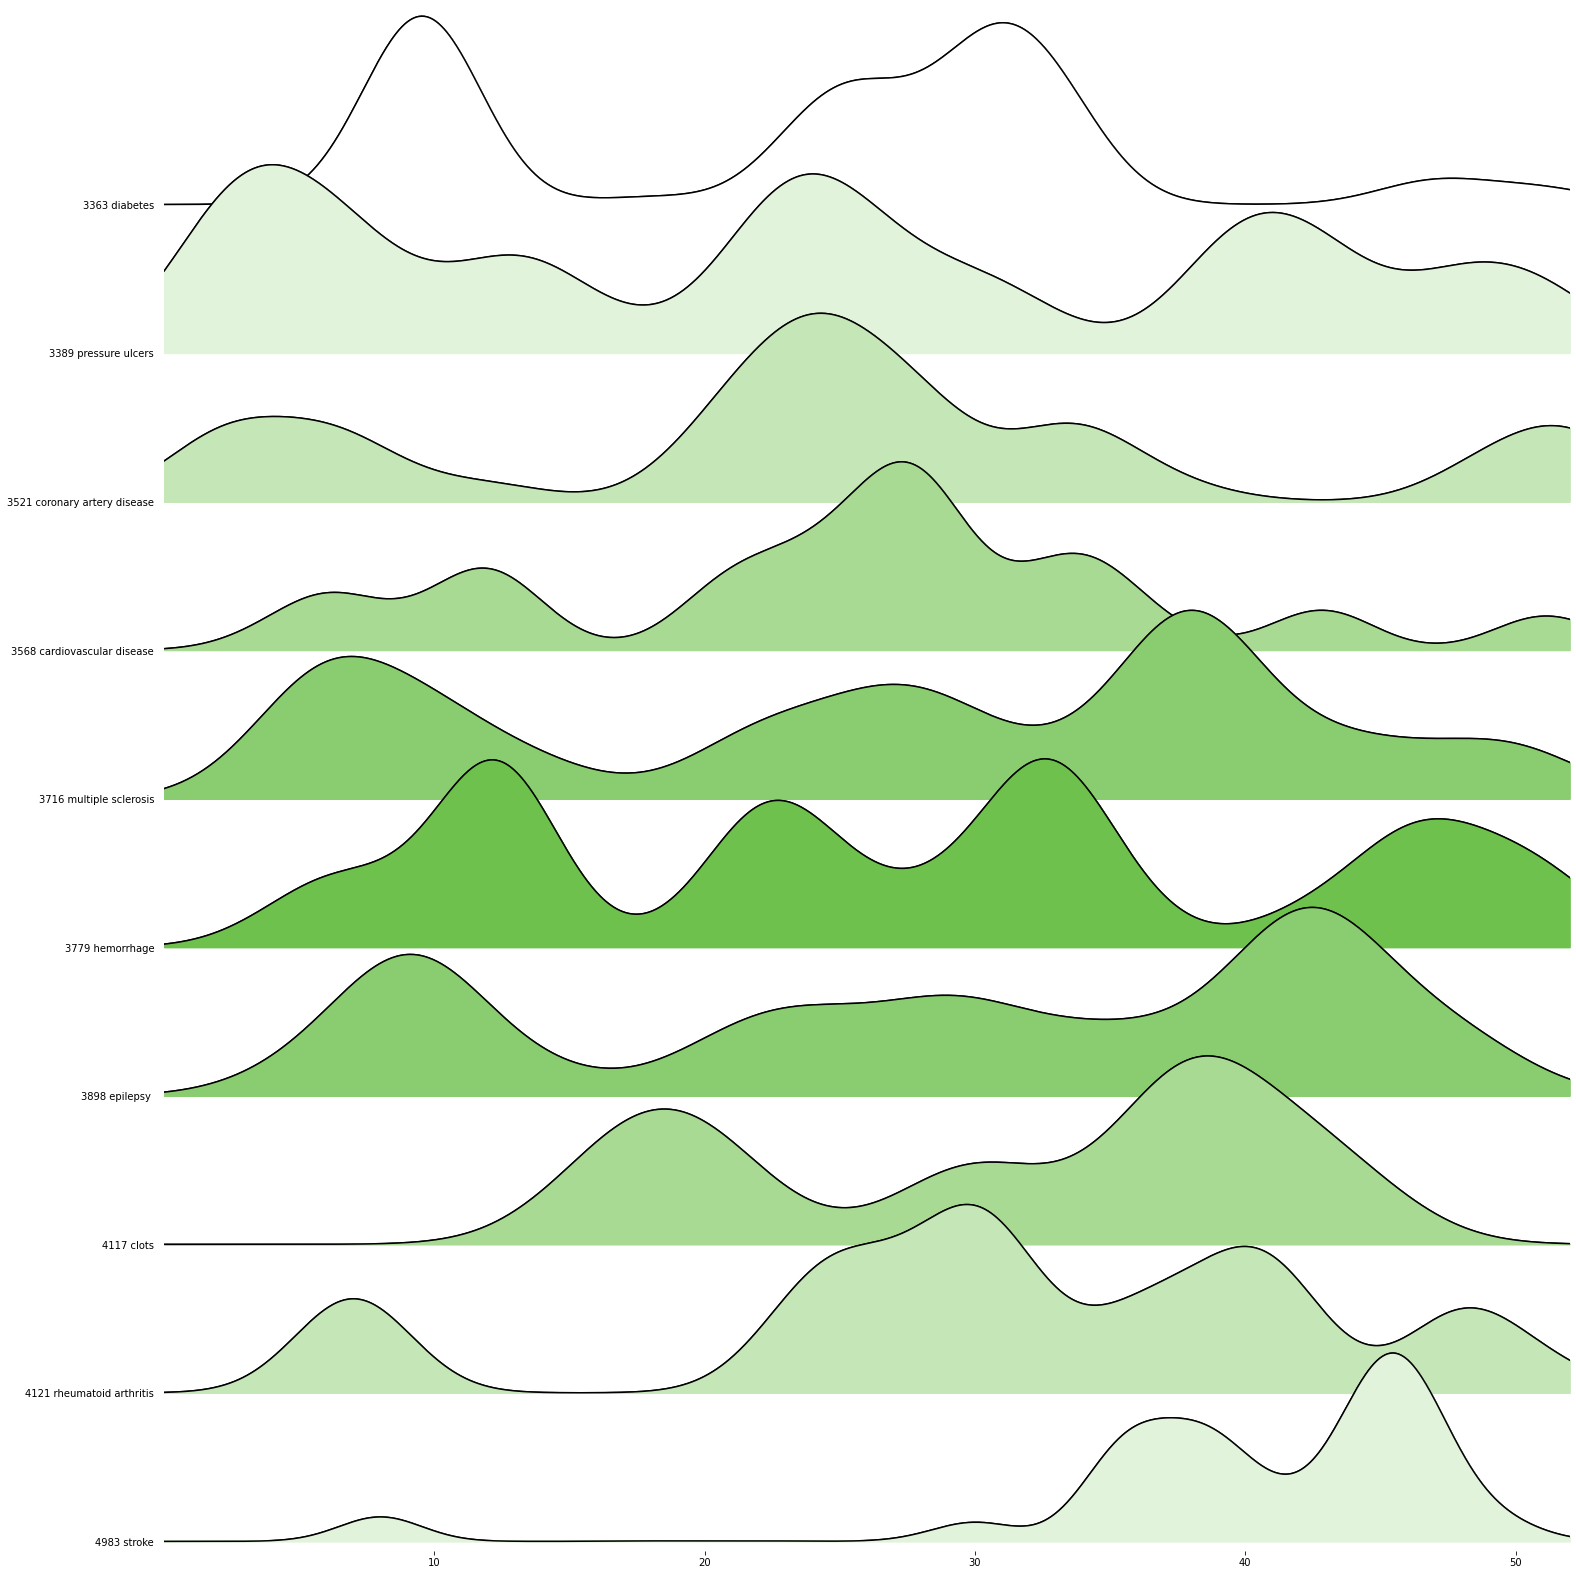

In [57]:
# request features
df_features = get_trend_frame(topics, '5', 'TX')

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events

get_ridgeplot(df_flat)

prompt
prompt
stroke multiple sclerosis
cardiovascular disease hemorrhage
diabetes coronary artery disease

   UNWIND $rows as row
   MATCH (p:prompt {prompt:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:prompt {prompt: right_value})
    MERGE (p)-[:IN_CATEGORY]->(c)
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:prompt {prompt:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:prompt {prompt: right_value})
    MERGE (p)-[:IN_CATEGORY]->(c)
    RETURN count(distinct p) as total
   


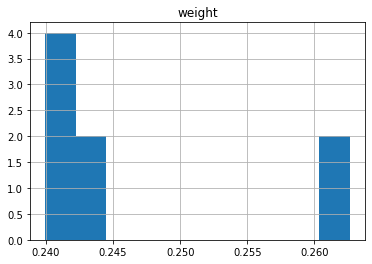

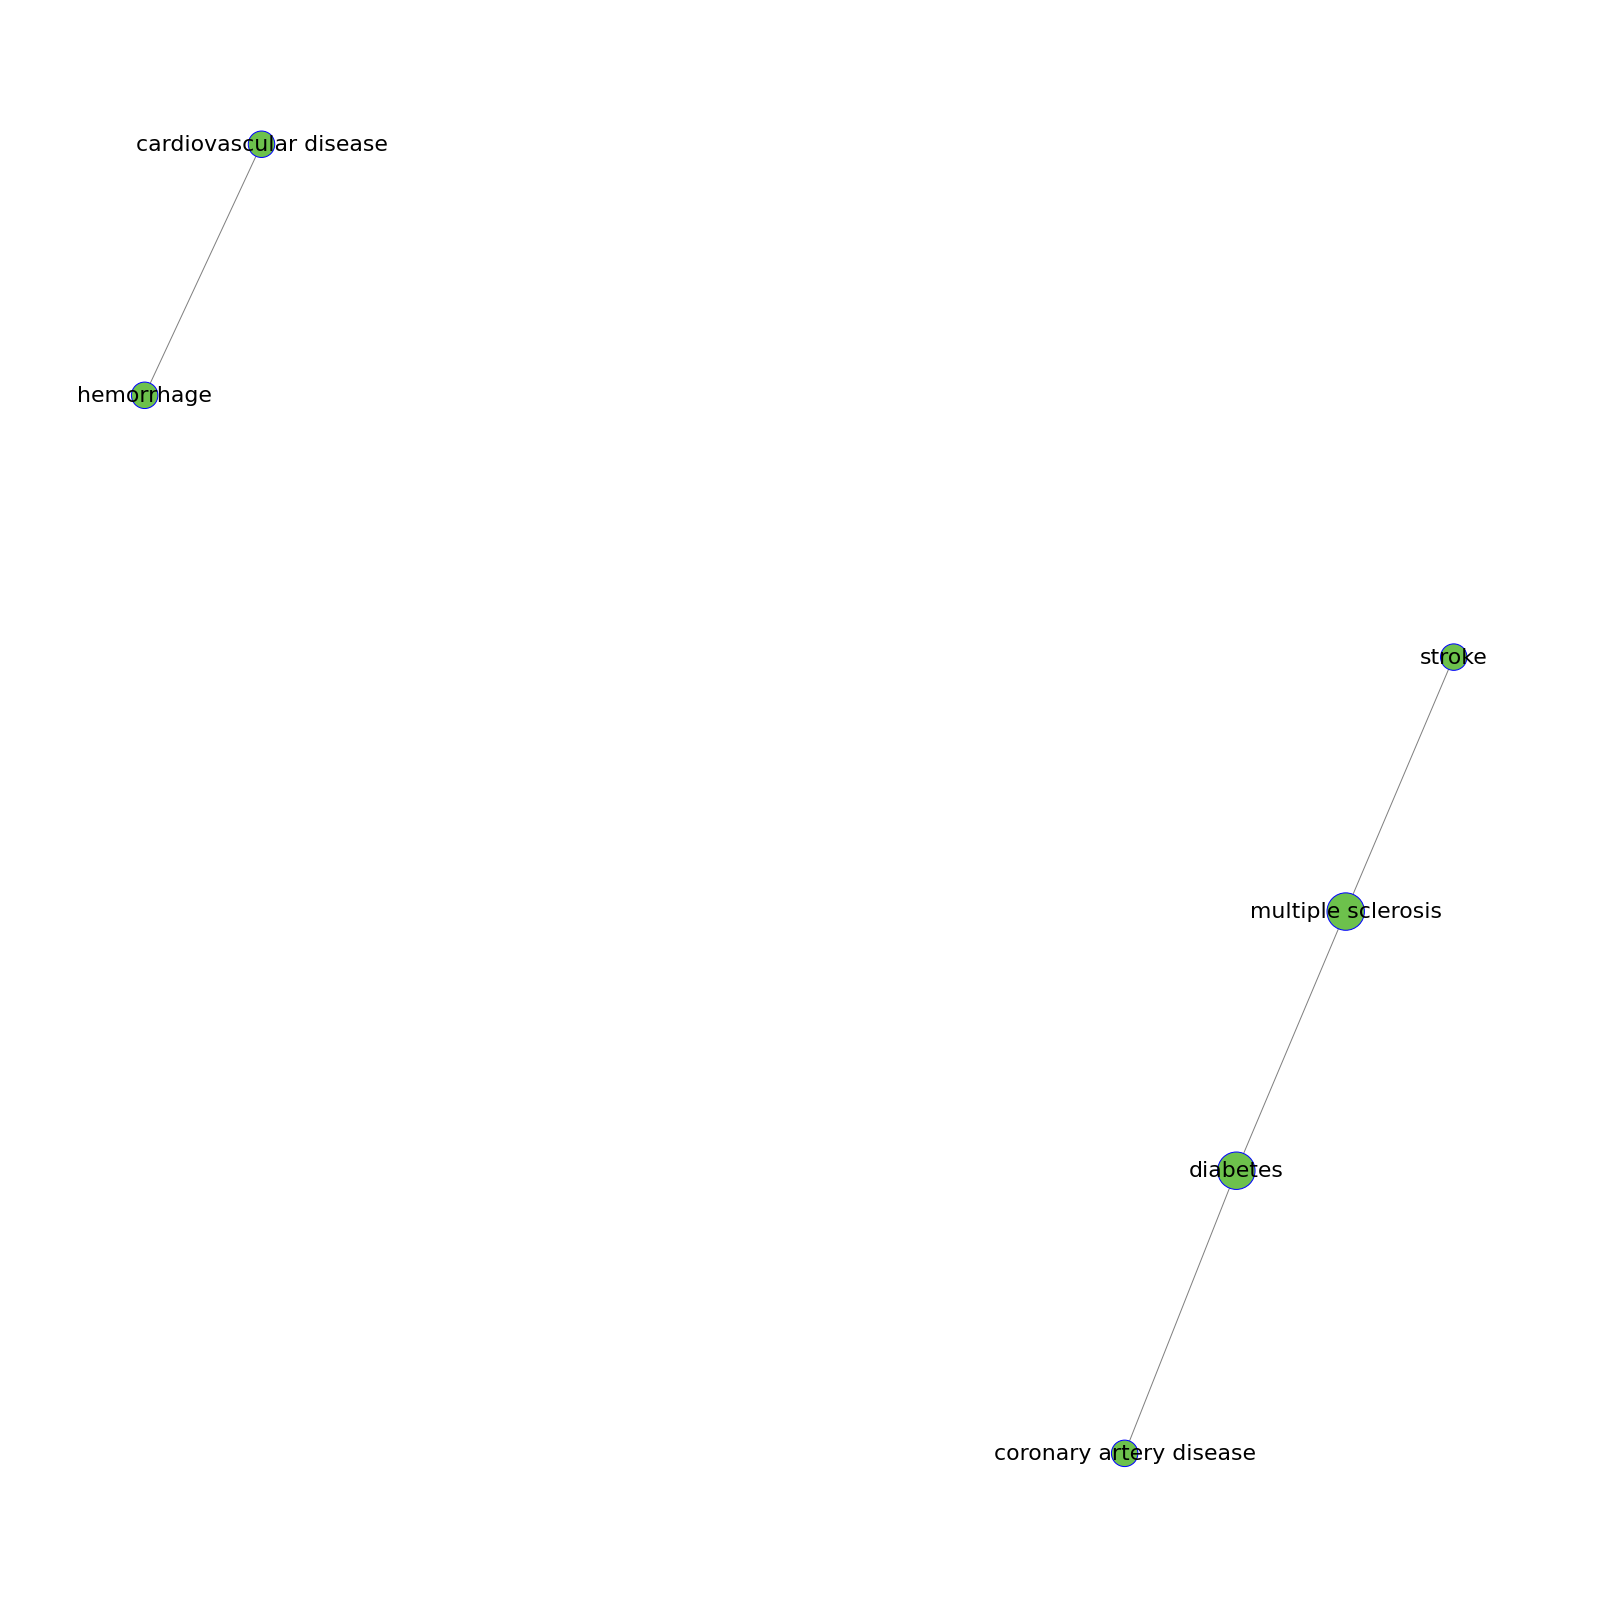

In [84]:
# ensure single way relationships
edge_track = {}

## time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, topics, std_factor)

# display flattened histogram
df_slice.hist()

# node label, entity type
entity_type = 'prompt'

# write nodes
write_node(df_slice[~df_slice['source'].isin(list(node_labels))], 'source', entity_type)

# record node label
for node in df_slice[~df_slice['source'].isin(list(node_labels))]['source']:
  node_labels[node] = entity_type

# record edges
df_slice_buffer = df_slice
df_slice_buffer['source_label'] = [ node_labels[i] for i in df_slice_buffer['source'] ]
df_slice_buffer['target_label'] = [ node_labels[i] for i in df_slice_buffer['target'] ]
df_distinct = df_slice.groupby(['source_label','target_label']).size().reset_index().rename(columns={0:'count'})

# for each distinct combination of labels / related nodes
for row in df_distinct.iterrows():
  df_slice_worker = df_slice_buffer
  distinct_combination_source_label = row[1][0]
  distinct_combination_target_label = row[1][1]

  print(distinct_combination_source_label)
  print(distinct_combination_target_label)

  # reduce relationships to involved vertex
  df_slice_worker = df_slice_worker.loc[df_slice_worker['source_label'] == distinct_combination_source_label]
  df_slice_worker = df_slice_worker.loc[df_slice_worker['target_label'] == distinct_combination_target_label]

  # remove duplicate relationships, iterate throug heach relationship
  for i in range(0,len(df_slice_worker)):

    # if node and relationships have been recorded before
    if df_slice_worker['target'][i] in edge_track:

      # if recorded relationship is not a duplicate of previously recorded relationship  
      if edge_track[df_slice_worker['target'][i]] != df_slice_worker['source'][i]:
        edge_track[df_slice_worker['source'][i]] = df_slice_worker['target'][i]
    
    # if node and relationship havent yet been recorded
    else:
      edge_track[df_slice_worker['source'][i]] = df_slice_worker['target'][i]

  # iterate through duplicated relationships
  for key, val in edge_track.items():

    # filter relatioinships without duplcate
    df_slice_worker = df_slice_worker.loc[(df_slice_worker['source'] != key) 
                                            & (df_slice_worker['target'] !=  val)]

  # create relationship
  add_edges(df_slice_worker, 'source', 'target'  # edges and directional weights
          , distinct_combination_source_label    # source label
          , distinct_combination_target_label )  # target label


# build graph
G = build_graph_network(df_slice)
Texas_orginal_G = G

In [79]:
edge_track
df_slice_worker

,source,target,weight,source_label,target_label
0,stroke,multiple sclerosis,0.239969,prompt,prompt
1,multiple sclerosis,stroke,0.239969,prompt,prompt
2,cardiovascular disease,hemorrhage,0.241901,prompt,prompt
3,hemorrhage,cardiovascular disease,0.241901,prompt,prompt
4,diabetes,multiple sclerosis,0.244072,prompt,prompt
5,multiple sclerosis,diabetes,0.244072,prompt,prompt
6,diabetes,coronary artery disease,0.262631,prompt,prompt
7,coronary artery disease,diabetes,0.262631,prompt,prompt


Communities found - 3 

Community 0 - ['arterial', 'cardiovascular disease', 'coronary artery disease', 'obesity', 'pressure ulcers', 'rheumatoid arthritis']
Community 1 - ['cancer', 'diabetes', 'hemorrhage', 'multiple sclerosis', 'stroke']
Community 2 - ['alzheimer', 'arthritis', 'clots', 'high blood pressure']


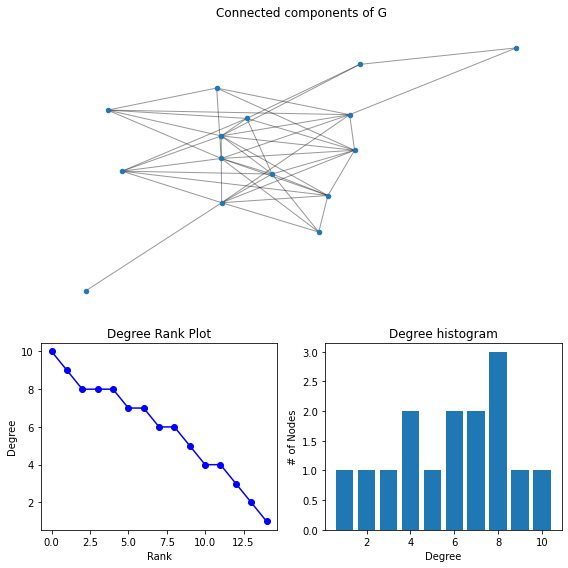

In [ ]:
# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

# print communitied
for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

# demonstrate graph degrees
get_graph_degree(G)

### Texas Generative Wave 1

In [ ]:
# prompt = "list single words that are important aspects of wound care"
# result_length = 100
# inputs = tokenizer(prompt, return_tensors="pt")
# print(inputs)

# print(tokenizer.decode(model.generate(inputs["input_ids"], 
#                        max_length=result_length
#                       )[0]))

# print(tokenizer.decode(model.generate(inputs["input_ids"],
#                        max_length=result_length, 
#                        num_beams=2, 
#                        no_repeat_ngram_size=2,
#                        early_stopping=True
#                       )[0]))

# # Sampling Top-k + Top-p
# print(tokenizer.decode(model.generate(inputs["input_ids"],
#                        max_length=result_length, 
#                        do_sample=True, 
#                        top_k=50, 
#                        top_p=0.9
#                       )[0]))

In [ ]:
# question = 'list single words'
# input_tokens = tokenizer(question, return_tensors="pt").to(0)
# prompt_bloom(question)

# #result = get_bloom_response(input_tokens)
# #print(result)


In [ ]:
# existing community topics
chk_topics = list(df_slice['source'].unique())

# purposed community topics
new_topics = get_related_topics(df_slice
                               , context = 'elderly'
                               , perspective = 'Texas') 
                                 
#new_topics = get_related_topics(df_slice, 'Texas')
#print(new_topics)

# new topic list
gen_topics = list(set(swap_tokens(chk_topics, new_topics)))
#print(gen_topics)

from the perspetive of Texas resident, list single words diet topics linked to coronary artery disease
['-fried foods \n\n -processed meats']
['-fried foods ', '', ' -processed meats']
[]
from the perspetive of Texas resident, list single words activities topics linked to coronary artery disease
['smoking, eating fatty foods.']
['smoking', 'eating fatty foods.']
['smoking']
from the perspetive of Texas resident, list single words regional topics linked to coronary artery disease
['-heart attack \n\n-"hardening of the arteries" (atherosclerosis)']
['-heart attack ', '', '-"hardening of the arteries" (atherosclerosis)']
['smoking']
from the perspetive of Texas resident, list single words holidays topics linked to coronary artery disease
["Christmas, New Year's Day"]
['christmas', "new year's day"]
['smoking', 'christmas']
from the perspetive of Texas resident, list single words seasonal topics linked to coronary artery disease
["Christmas, New Year's Eve"]
['christmas', "new year's eve"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


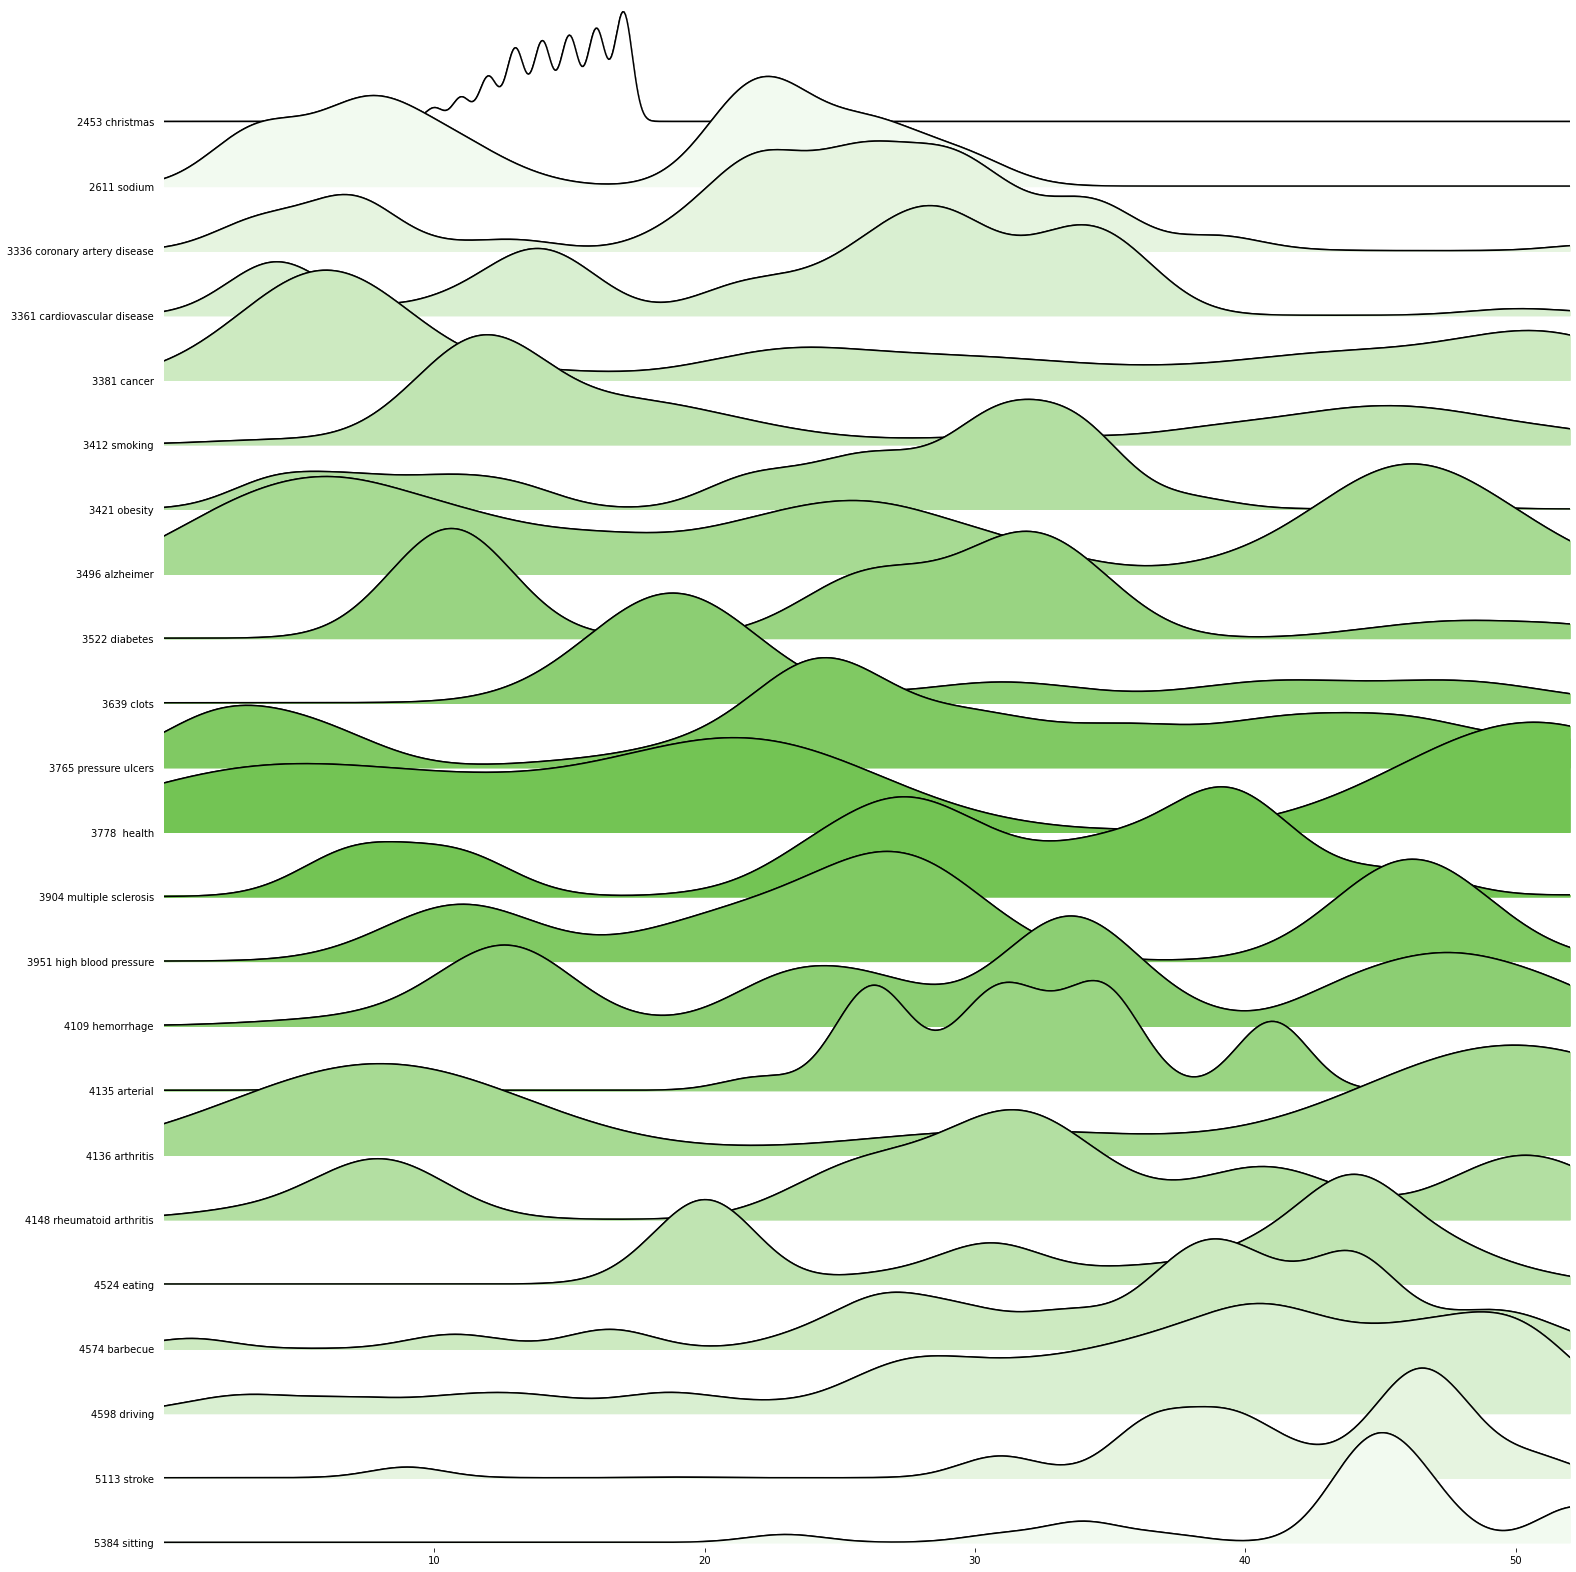

In [ ]:
# request features
df_features = get_trend_frame(gen_topics, '5', 'TX')

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)


   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:generated_wave_1 {generated_wave_1: right_value})
    MERGE (p)-[:IN_CATEGORY]->(c)
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:generated_wave_1 {generated_wave_1: right_value})
    MERGE (p)-[:IN_CATEGORY]->(c)
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:prompt {prompt: right_value})
    MERGE (p)-[:IN_CATEGORY]->(c)
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:prompt {prompt: right_value})


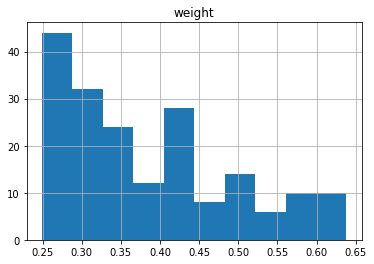

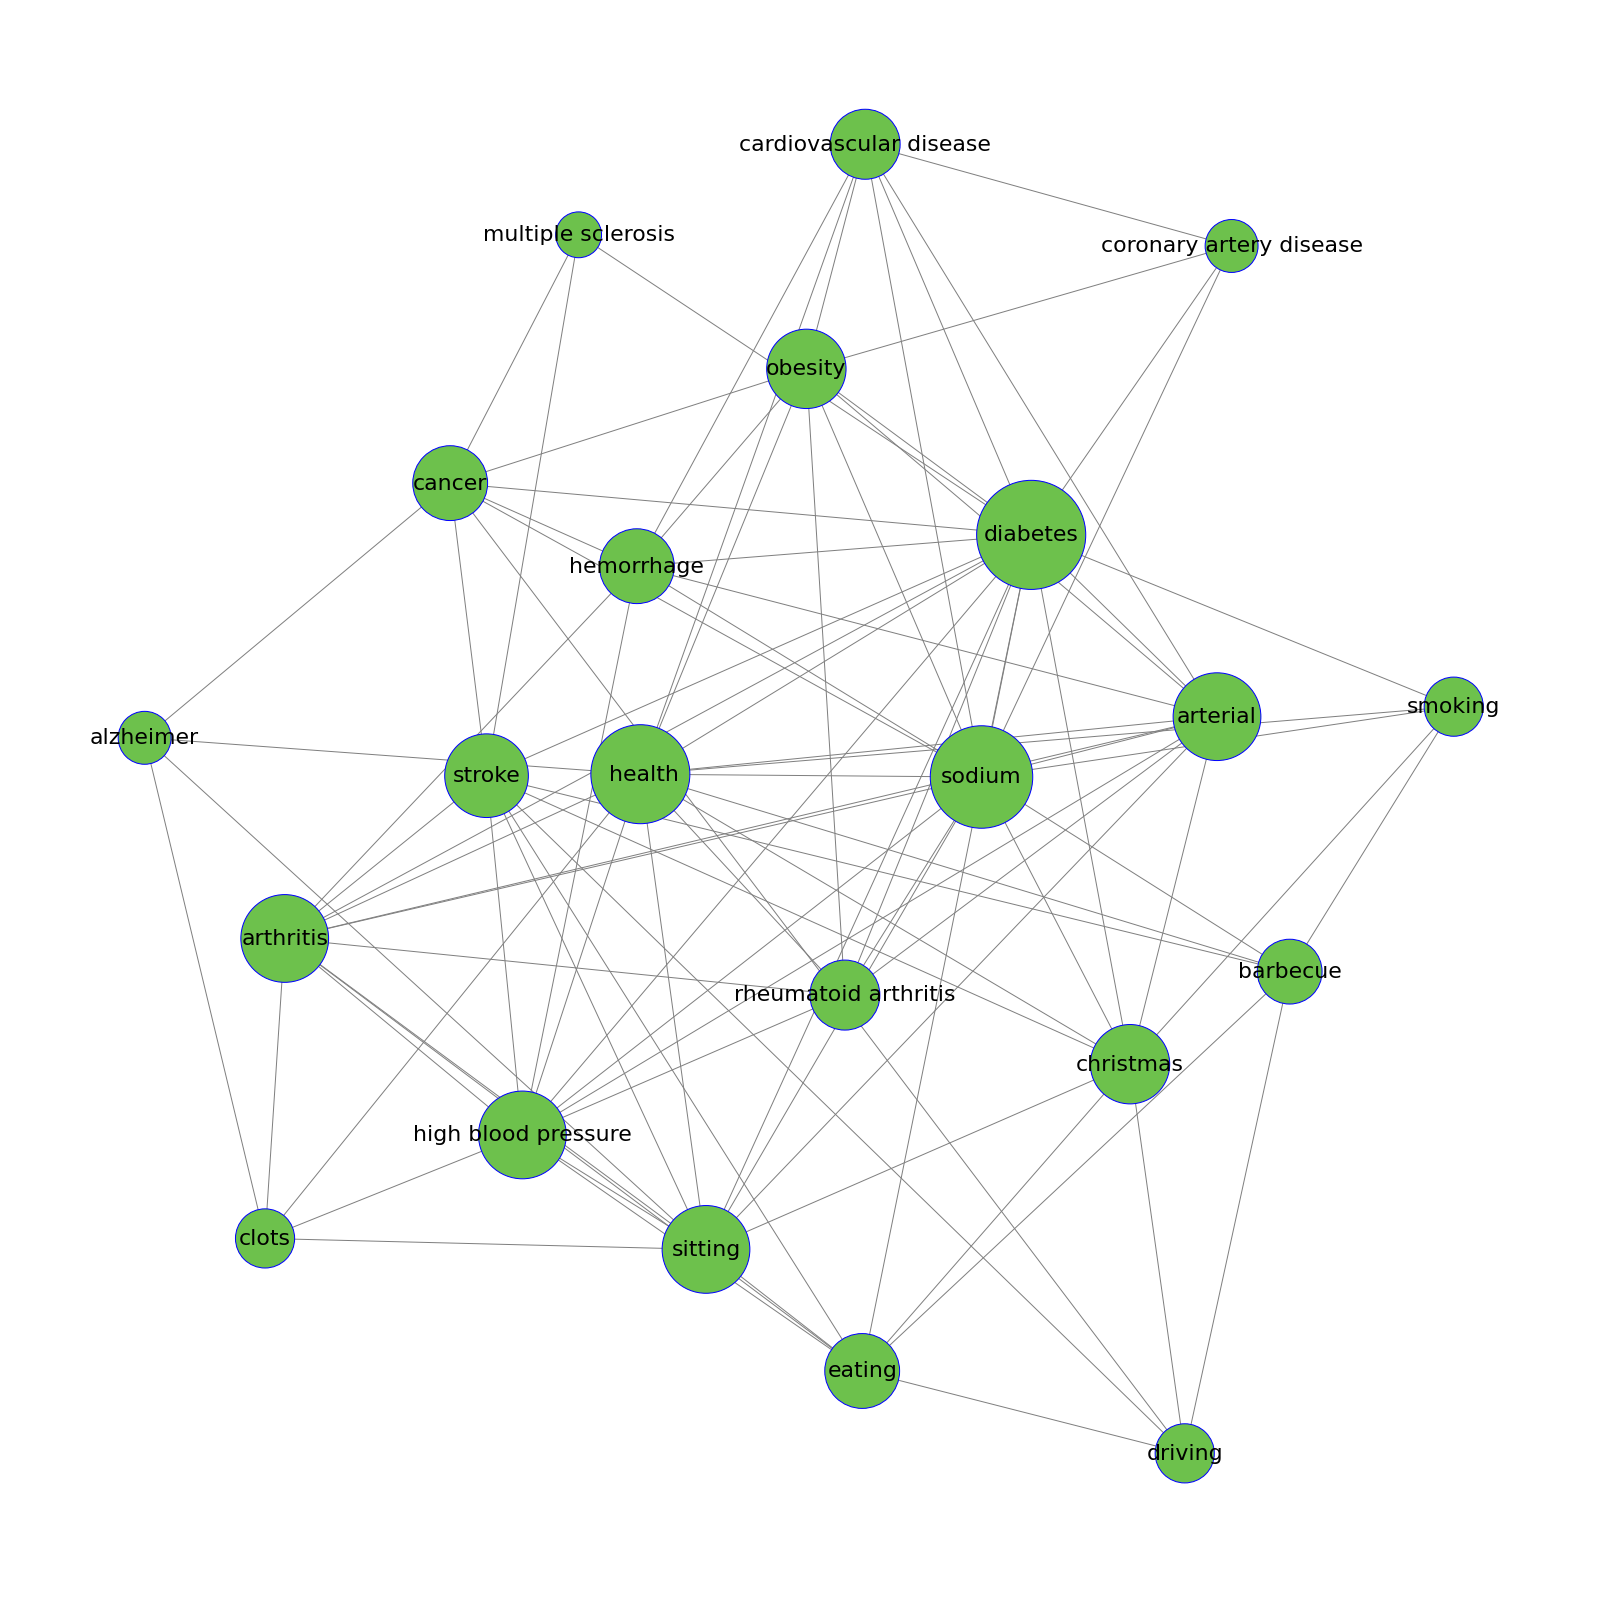

In [ ]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, gen_topics, std_factor)

# reduce to relevant relationships
df_slice = df_slice[(df_slice['weight'] < max_similarity)]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()

# node label, entity type
entity_type = 'generated_wave_1'


# write nodes
write_node(df_slice[~df_slice['source'].isin(list(node_labels))], 'source', entity_type)

# record node label
for node in df_slice[~df_slice['source'].isin(list(node_labels))]['source']:
  node_labels[node] = entity_type

# record edges
df_slice_buffer = df_slice
df_slice_buffer['source_label'] = [ node_labels[i] for i in df_slice_buffer['source'] ]
df_slice_buffer['target_label'] = [ node_labels[i] for i in df_slice_buffer['target'] ]
df_distinct = df_slice.groupby(['source_label','target_label']).size().reset_index().rename(columns={0:'count'})

# for each distinct combination of labels / related nodes
for row in df_distinct.iterrows():
  df_slice_worker = df_slice_buffer
  distinct_combination_source_label = row[1][0]
  distinct_combination_target_label = row[1][1]

  print(distinct_combination_source_label)
  print(distinct_combination_target_label)

  # reduce relationships to involved vertex
  df_slice_worker = df_slice_worker.loc[df_slice_worker['source_label'] == distinct_combination_source_label]
  df_slice_worker = df_slice_worker.loc[df_slice_worker['target_label'] == distinct_combination_target_label]

  # remove duplicate relationships, iterate throug heach relationship
  for i in range(0,len(df_slice_worker)):

    # if node and relationships have been recorded before
    if df_slice_worker['target'][i] in edge_track:

      # if recorded relationship is not a duplicate of previously recorded relationship  
      if edge_track[df_slice_worker['target'][i]] != df_slice_worker['source'][i]:
        edge_track[df_slice_worker['source'][i]] = df_slice_worker['target'][i]
    
    # if node and relationship havent yet been recorded
    else:
      edge_track[df_slice_worker['source'][i]] = df_slice_worker['target'][i]

  # iterate through duplicated relationships
  for key, val in edge_track.items():

    # filter relatioinships without duplcate
    df_slice_worker = df_slice_worker.loc[(df_slice_worker['source'] != key) 
                                            & (df_slice_worker['target'] !=  val)]

  # create relationship
  add_edges(df_slice_worker, 'source', 'target'  # edges and directional weights
          , distinct_combination_source_label    # source label
          , distinct_combination_target_label )  # target label

# build graph
G = build_graph_network(df_slice)
Texas_genwave_1_G = G

Communities found - 3 

Community 0 - ['barbecue', 'cancer', 'christmas', 'driving', 'eating', 'multiple sclerosis', 'smoking', 'stroke']
Community 1 - [' health', 'alzheimer', 'arterial', 'arthritis', 'clots', 'high blood pressure', 'rheumatoid arthritis', 'sitting']
Community 2 - ['cardiovascular disease', 'coronary artery disease', 'diabetes', 'hemorrhage', 'obesity', 'sodium']


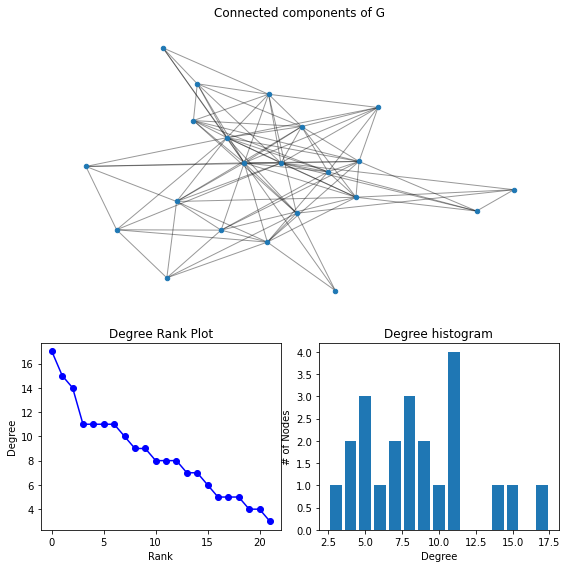

In [ ]:
# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

# print communitied
for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

# demonstrate graph degrees
get_graph_degree(G)

In [ ]:
# TOP 10 Connective Nodes
sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]

[('diabetes', 17),
 ('sodium', 15),
 (' health', 14),
 ('arterial', 11),
 ('high blood pressure', 11),
 ('arthritis', 11),
 ('sitting', 11),
 ('stroke', 10),
 ('christmas', 9),
 ('obesity', 9)]

### Texas generative wave 2

In [ ]:
# existing community topics
chk_topics = list(df_slice['source'].unique())

# purposed community topics
# new_topics = get_related_topics(df_slice, 'Texas')
new_topics = get_related_topics(df_slice
                               , context = 'elderly'
                               , perspective = 'Texas') 

# new topic list
gen_topics = list(set(swap_tokens(chk_topics, new_topics)))
#print(gen_topics)

from the perspetive of Texas resident, list single words diet topics linked to coronary artery disease
['-saturated fats \n\n -trans fatty acids, cholesterol']
['-saturated fats ', '', ' -trans fatty acids', 'cholesterol']
[]
from the perspetive of Texas resident, list single words activities topics linked to coronary artery disease
['smoking, eating unhealthy foods']
['smoking', 'eating unhealthy foods']
['smoking']
from the perspetive of Texas resident, list single words regional topics linked to coronary artery disease
['-smoking, obesity/sedentary lifestyle']
['-smoking', 'obesity/sedentary lifestyle']
['smoking', 'smoking']
from the perspetive of Texas resident, list single words holidays topics linked to coronary artery disease
["Christmas, New Year's Day"]
['christmas', "new year's day"]
['smoking', 'smoking', 'christmas']
from the perspetive of Texas resident, list single words seasonal topics linked to coronary artery disease
["Christmas, New Year's Day"]
['christmas', "new ye

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


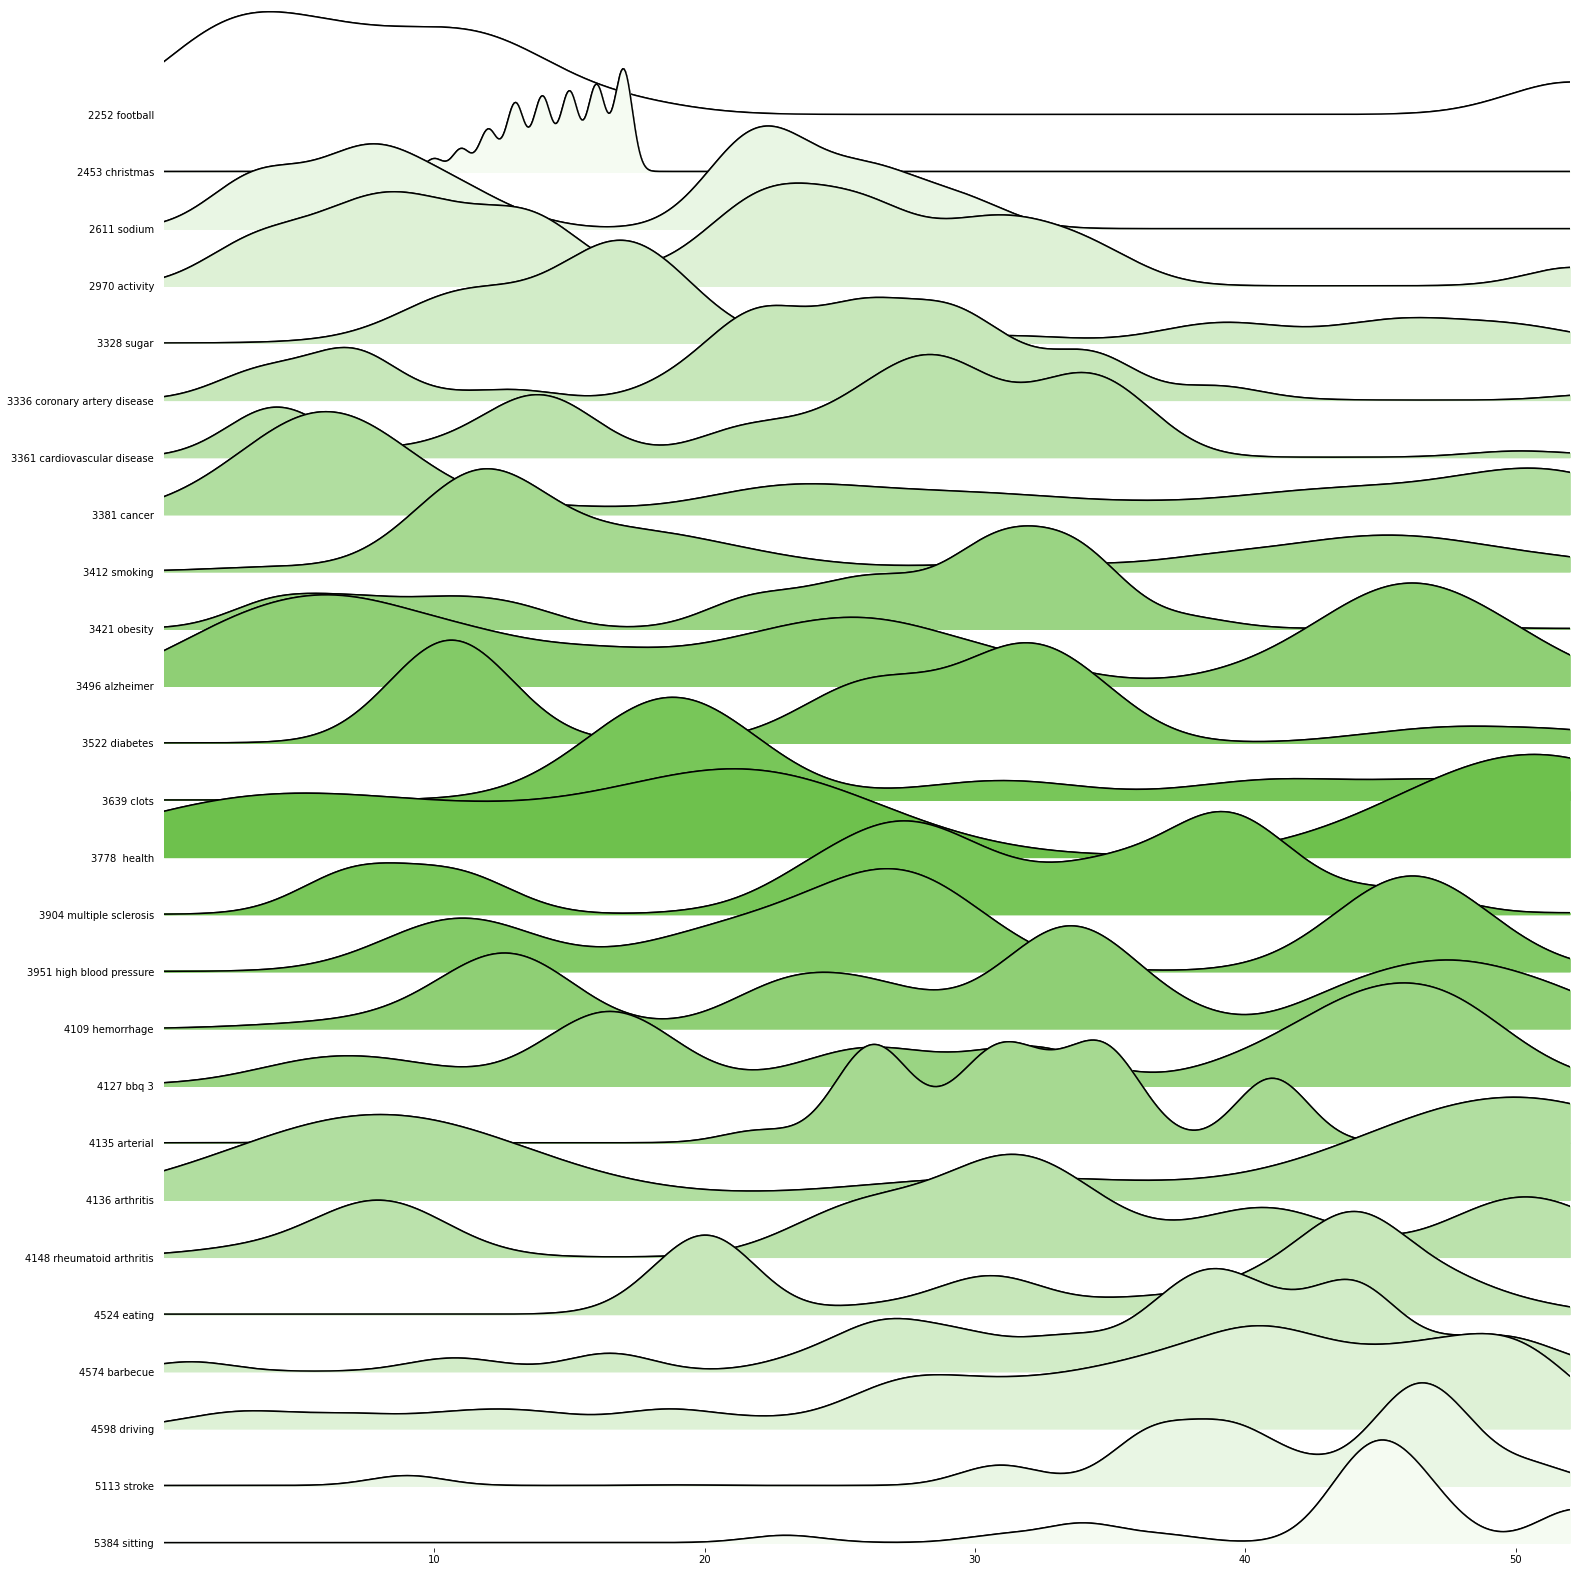

In [ ]:
# request features
df_features = get_trend_frame(gen_topics, '5', 'TX')

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)


   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:generated_wave_1 {generated_wave_1: right_value})
    MERGE (p)-[:IN_CATEGORY]->(c)
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:generated_wave_1 {generated_wave_1: right_value})
    MERGE (p)-[:IN_CATEGORY]->(c)
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:generated_wave_2 {generated_wave_2: right_value})
    MERGE (p)-[:IN_CATEGORY]->(c)
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:generated_

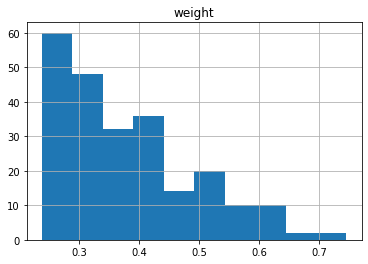

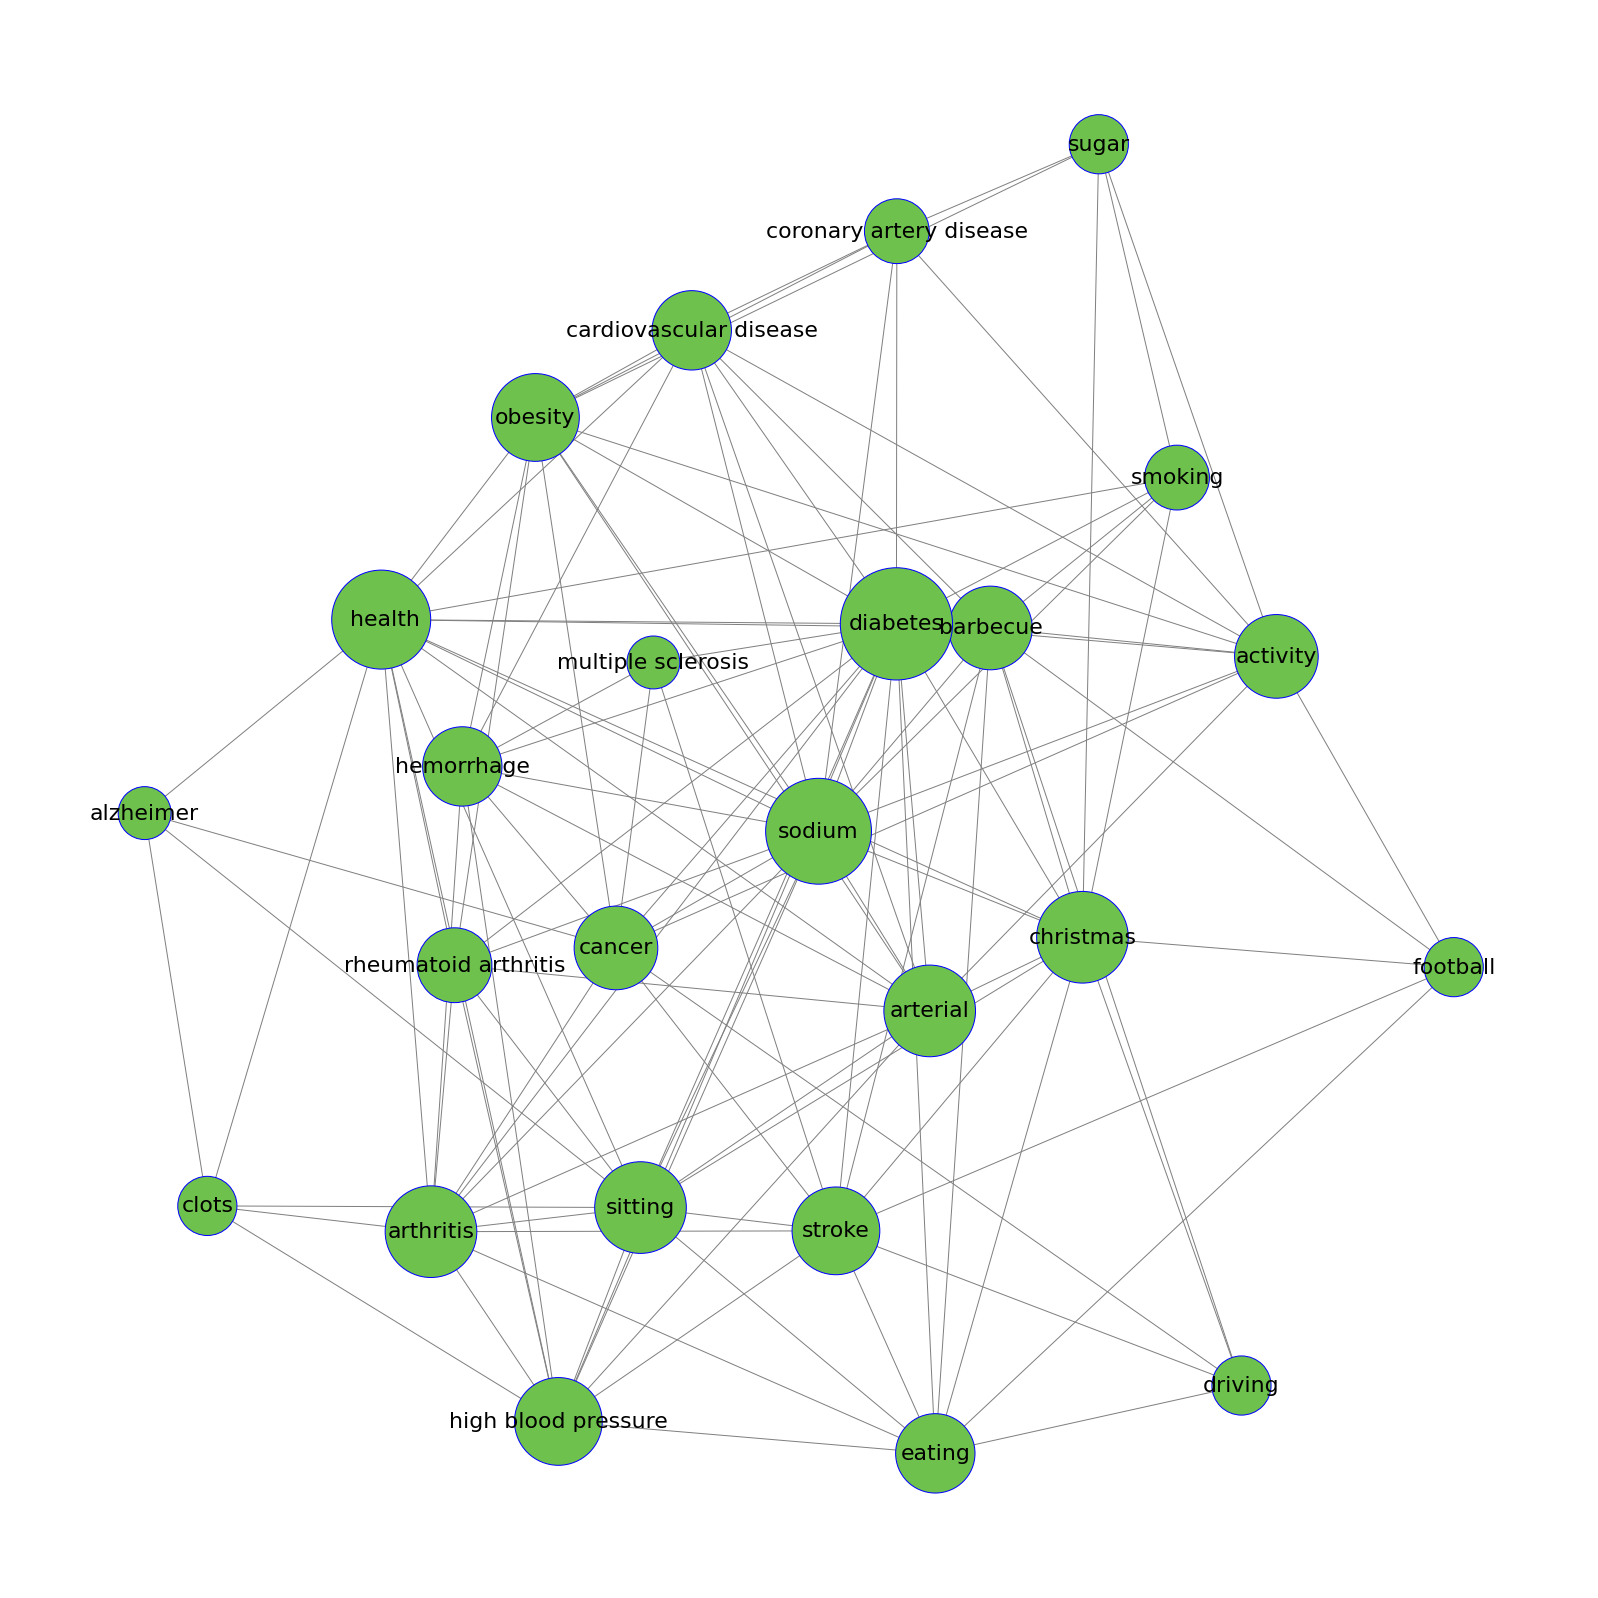

In [ ]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, gen_topics, std_factor*2)

# reduce to relevant relationships
df_slice = df_slice[(df_slice['weight']< max_similarity )]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()


# node label, entity type
entity_type = 'generated_wave_2'

# write nodes
write_node(df_slice[~df_slice['source'].isin(list(node_labels))], 'source', entity_type)

# record node label
for node in df_slice[~df_slice['source'].isin(list(node_labels))]['source']:
  node_labels[node] = entity_type

# record edges
df_slice_buffer = df_slice
df_slice_buffer['source_label'] = [ node_labels[i] for i in df_slice_buffer['source'] ]
df_slice_buffer['target_label'] = [ node_labels[i] for i in df_slice_buffer['target'] ]
df_distinct = df_slice.groupby(['source_label','target_label']).size().reset_index().rename(columns={0:'count'})

# for each distinct combination of labels / related nodes
for row in df_distinct.iterrows():
  df_slice_worker = df_slice_buffer
  distinct_combination_source_label = row[1][0]
  distinct_combination_target_label = row[1][1]

  print(distinct_combination_source_label)
  print(distinct_combination_target_label)

  # reduce relationships to involved vertex
  df_slice_worker = df_slice_worker.loc[df_slice_worker['source_label'] == distinct_combination_source_label]
  df_slice_worker = df_slice_worker.loc[df_slice_worker['target_label'] == distinct_combination_target_label]

  # remove duplicate relationships, iterate throug heach relationship
  for i in range(0,len(df_slice_worker)):

    # if node and relationships have been recorded before
    if df_slice_worker['target'][i] in edge_track:

      # if recorded relationship is not a duplicate of previously recorded relationship  
      if edge_track[df_slice_worker['target'][i]] != df_slice_worker['source'][i]:
        edge_track[df_slice_worker['source'][i]] = df_slice_worker['target'][i]
    
    # if node and relationship havent yet been recorded
    else:
      edge_track[df_slice_worker['source'][i]] = df_slice_worker['target'][i]

  # iterate through duplicated relationships
  for key, val in edge_track.items():

    # filter relatioinships without duplcate
    df_slice_worker = df_slice_worker.loc[(df_slice_worker['source'] != key) 
                                            & (df_slice_worker['target'] !=  val)]

  # create relationship
  add_edges(df_slice_worker, 'source', 'target'  # edges and directional weights
          , distinct_combination_source_label    # source label
          , distinct_combination_target_label )  # target label

# build graph
G = build_graph_network(df_slice)
Texas_genwave_2_G = G

Communities found - 4 

Community 0 - [' health', 'alzheimer', 'arterial', 'arthritis', 'clots', 'high blood pressure', 'rheumatoid arthritis', 'sitting']
Community 1 - ['activity', 'cardiovascular disease', 'coronary artery disease', 'obesity', 'sodium', 'sugar']
Community 2 - ['cancer', 'diabetes', 'driving', 'hemorrhage', 'multiple sclerosis', 'stroke']
Community 3 - ['barbecue', 'christmas', 'eating', 'football', 'smoking']


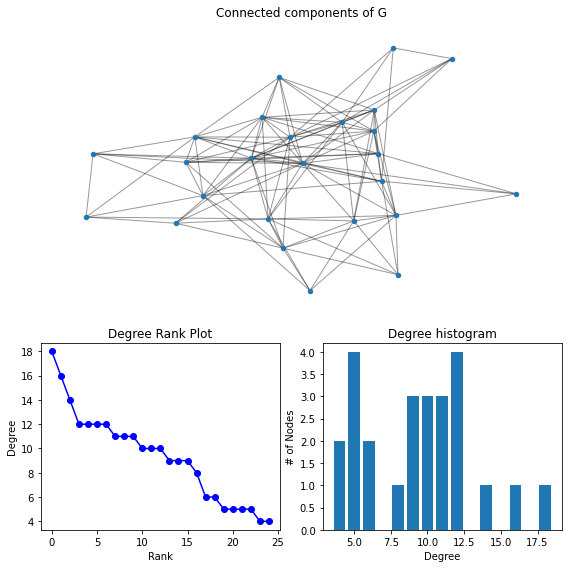

In [ ]:
# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

# print communitied
for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

# demonstrate graph degrees
get_graph_degree(G)

In [ ]:
# TOP 10 Connective Nodes
sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]

[('diabetes', 18),
 ('sodium', 16),
 (' health', 14),
 ('arthritis', 12),
 ('christmas', 12),
 ('sitting', 12),
 ('arterial', 12),
 ('obesity', 11),
 ('high blood pressure', 11),
 ('stroke', 11)]

['Florida-cancer', 'Florida-arthritis', 'Florida-sugar', 'Florida-coronary artery disease', 'Florida-christmas', 'Florida-barbecue', 'Florida-hemorrhage', 'Florida-multiple sclerosis', 'Florida-cardiovascular disease', 'Florida-sitting', 'Florida-rheumatoid arthritis', 'Florida-diabetes', 'Florida-arterial', 'Florida-obesity', 'Florida-sodium', 'Florida-high blood pressure', 'Florida-stroke', 'Florida-activity', 'Florida-football', 'Florida- health', 'Florida-alzheimer', 'Florida-smoking', 'Florida-clots', 'Florida-eating', 'Florida-driving', 'Texas-coronary artery disease', 'Texas-diabetes', 'Texas-hemorrhage', 'Texas-cancer', 'Texas-arterial', 'Texas-christmas', 'Texas-obesity', 'Texas-sodium', 'Texas-stroke', 'Texas-high blood pressure', 'Texas-multiple sclerosis', 'Texas- health', 'Texas-alzheimer', 'Texas-arthritis', 'Texas-rheumatoid arthritis', 'Texas-smoking', 'Texas-barbecue', 'Texas-sitting', 'Texas-clots', 'Texas-eating', 'Texas-cardiovascular disease', 'Texas-driving']


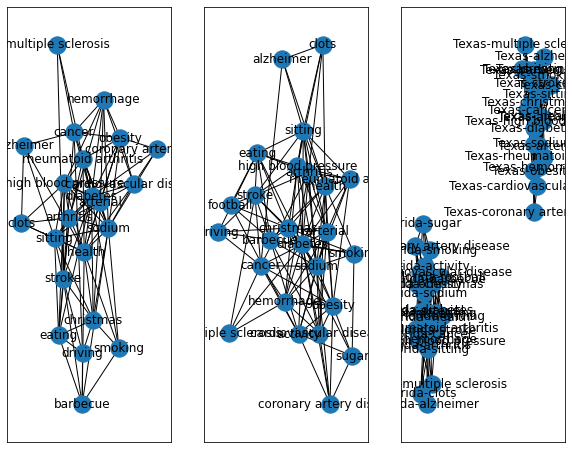

In [ ]:
# visualizations.draw_graph_overlap(G,orginal_G,edge_width=5,node_name_1="Type 2 diabetes",node_name_2="Type 2 diabetes",physics_enabled=False)
_,ax = plt.subplots(1,3, figsize=(10,8))
nx.draw_networkx(Texas_genwave_1_G, ax=ax[0])
nx.draw_networkx(Texas_genwave_2_G, ax=ax[1])
U = nx.union(Texas_genwave_2_G, Texas_genwave_1_G, rename=('Florida-','Texas-'))
#U = nx.union(G, orginal_G, rename=('T','T'))
#U = nx.disjoint_union(G, orginal_G)
nx.draw_networkx(U, ax=ax[2])
print(U.nodes())

{}

In [25]:
try:
  gds.graph.drop(G)
except:
  print('graph not created yet')

# G, _ = gds.graph.get("dehls_health_temporal")
# G, _ = gds.graph.project("neo4j_6")
# G, _ = gds.graph.project("neo4j_6", "source", "IN_CATEGORY")
G, _ = gds.graph.project("neo4j_6", ['prompt', 'generated_wave_1'], "IN_CATEGORY")

graph not created yet


Loading:   0%|          | 0/100 [00:00<?, ?%/s]

{}


In [51]:
# query aurads
q1="MATCH (n) return ID(n), LABELS(n), PROPERTIES(n)"
nodes = conn.query(q1)

# node buffer
node_map = {}

# for each returned node
for row in nodes:
  row_rec_idx = 0
  row_rec_chk = 0
  
  # for each item in row record
  for prop in row:

    # record nodes id
    if row_rec_idx == 0:
      node_id = prop
      row_rec_chk += 1

    # record node label
    if row_rec_idx == 1:
      node_label = prop[0]
      row_rec_chk += 1

    # record node name
    if row_rec_idx == 2:
      node_name = list(prop.values())[0]
      row_rec_chk += 1


    if row_rec_chk ==3:
      node_map[node_id] = [node_name, node_label]


    row_rec_idx += 1
  

In [48]:
node_map

{20: ['multiple sclerosis', 'prompt'],
 21: ['hemorrhage', 'prompt'],
 22: ['diabetes', 'prompt'],
 23: ['stroke', 'prompt'],
 24: ['coronary artery disease', 'prompt'],
 25: ['cardiovascular disease', 'prompt'],
 26: ['walk', 'generated_wave_1'],
 27: ['arterial', 'prompt'],
 28: ['obesity', 'prompt'],
 29: ['pressure ulcers', 'prompt'],
 30: ['arthritis', 'prompt'],
 31: ['rheumatoid arthritis', 'prompt'],
 32: ['cancer', 'prompt'],
 33: ['high blood pressure', 'prompt'],
 34: ['clots', 'prompt'],
 35: ['alzheimer', 'prompt'],
 36: ['christmas', 'generated_wave_1'],
 37: ['sodium', 'generated_wave_1'],
 38: [' health', 'generated_wave_1'],
 39: ['smoking', 'generated_wave_1'],
 46: ['barbecue', 'generated_wave_1'],
 47: ['sitting', 'generated_wave_1'],
 48: ['eating', 'generated_wave_1'],
 49: ['driving', 'generated_wave_1'],
 50: ['sugar', 'generated_wave_2'],
 51: ['activity', 'generated_wave_2'],
 52: ['football', 'generated_wave_2']}

In [29]:

# source_id = gds.find_node_id(["source"], {"source": "smoking"})
source_id = gds.find_node_id(["generated_wave_1"], {"generated_wave_1": "sitting"})
target_id = gds.find_node_id(["generated_wave_1"], {"generated_wave_1": "walk"})

res = gds.shortestPath.dijkstra.stream(G, sourceNode=source_id, targetNode=target_id)
# assert res["totalCost"][0] == 100



In [30]:
res

,index,sourceNode,targetNode,totalCost,nodeIds,costs,path
0,0,47,26,2.0,"[47, 22, 26]","[0.0, 1.0, 2.0]","((cost), (cost))"


In [50]:
nodes_ids = res.nodeIds
for nodes in nodes_ids:

  for node in nodes:

    print(node_map[node][0])


sitting
diabetes
walk


In [52]:
# adamicAdar link prediction
score = gds.alpha.linkprediction.adamicAdar(source_id, target_id)

print('adamicAdar link prediction - %f' % (score))


# total neighbors between to items
score = gds.alpha.linkprediction.totalNeighbors(source_id, target_id)

print('total neighbors - %f' % (score))


# common neighbors between to items
score = gds.alpha.linkprediction.commonNeighbors(source_id, target_id)

print('common neighbors - %f' % (score))

# same community between to items
score = gds.alpha.linkprediction.sameCommunity(source_id, target_id)

print('number of nodes in same commnuity - %f' % (score))

# same community between to items
# gds.
# score = gds.alpha.nodeSimilarity(source_id, target_id)

print('number of nodes in same commnuity - %f' % (score))


adamicAdar link prediction - 0.589566
total neighbors - 12.000000
common neighbors - 2.000000
number of nodes in same commnuity - 0.000000
number of nodes in same commnuity - 0.000000


In [53]:
res = gds.shortestPath.dijkstra.stream(G, sourceNode=source_id, targetNode=target_id)

In [55]:
res = gds.nodeSimilarity.stream(G, nodeLabels=['generated_wave_1','prompt','generated_wave_2'])
temp_res = res.copy()
temp_res['node1'] = [ node_map[i][0] for i in temp_res['node1'] ]
temp_res['node2'] = [ node_map[i][0] for i in temp_res['node2'] ]
print(temp_res.sort_values(by=['similarity'], ascending=False)[:20])
#print(temp_res)

                      node1                   node2  similarity
99                arthritis     high blood pressure    0.714286
129     high blood pressure               arthritis    0.714286
70                 arterial                  sodium    0.687500
169                  sodium                arterial    0.687500
20                 diabetes                  sodium    0.650000
170                  sodium                diabetes    0.650000
209                 sitting     high blood pressure    0.642857
130     high blood pressure                 sitting    0.642857
109    rheumatoid arthritis              hemorrhage    0.636364
10               hemorrhage    rheumatoid arthritis    0.636364
110    rheumatoid arthritis                arterial    0.615385
71                 arterial    rheumatoid arthritis    0.615385
171                  sodium                  health    0.611111
179                  health                  sodium    0.611111
219                  eating             